In [ ]:
import tensorflow as tf
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import keras.backend as K
 
from tqdm import tqdm 

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git
from tensorflow_examples.models.pix2pix import pix2pix

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-82qltx7o
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-82qltx7o
  Created wheel for tensorflow-examples: filename=tensorflow_examples-816dd54bf1f4fb9695d35732830b82ab67ad8836_-py3-none-any.whl size=271365 sha256=cb53e3122cde361678fbeb6a2bf318d9f97f412b02c30adb6f7d0a9dd4ea4dc2
  Stored in directory: /tmp/pip-ephem-wheel-cache-epopculj/wheels/eb/19/50/2a4363c831fa12b400af86325a6f26ade5d2cdc5b406d552ca
Failed to build tensorflow-examples
    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
IMAGE_PATH = "/content/drive/MyDrive/Work/Person-segmentation/data/images"
MASK_PATH = "/content/drive/MyDrive/Work/Person-segmentation/data/masks"
PREDICTION_PATH = "/content/drive/MyDrive/Work/Person-segmentation/predictions"
TEST_PATH = "/content/drive/MyDrive/Work/Person-segmentation/test"
AUTOTUNE = tf.data.experimental.AUTOTUNE
WIDTH, HEIGHT = 512, 512
BATCH_SIZE = 16

In [ ]:
def load_data(image_path, mask_path):
    images = sorted(glob(f"{image_path}/*.png"))
    masks = sorted(glob(f"{mask_path}/*.png"))
    return images, masks

image_files, mask_files = load_data(IMAGE_PATH, MASK_PATH)

print(len(image_files), len(mask_files))
DATASET_SIZE = len(image_files)

dataset = tf.data.Dataset.from_tensor_slices((image_files, mask_files))

2667 2667


In [ ]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32)/ 255.0
    input_image = tf.expand_dims(input_image, 0)
    
    #input_mask = tf.cast(input_mask, tf.uint8)
    input_mask = tf.cast(input_mask, tf.float32)/ 255.0
    input_mask = tf.expand_dims(input_mask, 0)
    #input_mask -= 1
    
    return input_image, input_mask


def parse_image(image_file, mask_file):
    img = tf.io.read_file(image_file)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, size=(WIDTH, HEIGHT))
    msk = tf.io.read_file(mask_file)
    msk = tf.image.decode_png(msk, channels=3)
    msk = tf.image.resize(msk, size=(WIDTH, HEIGHT))
    
    img, msk = normalize(img, msk)
    
    return img, msk

In [ ]:
dataset = dataset.map(parse_image) #.batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
def display(display_list):
    plt.figure(figsize=(WIDTH, HEIGHT))
    #print(display_list)
    title = ['input image', 'true mask', 'predicted mask']
    
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()
    
for image, mask in dataset.take(1):
    sample_image, sample_mask = image, mask
    
#display([sample_image[0], sample_mask[0]])

In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def dice_loss(in_gt, in_pred):
    return 1-dice_coef(in_gt, in_pred)

def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

def iou_loss(in_gt, in_pred):
    return 1-iou_coef(in_gt, in_pred)

In [ ]:
#Build the model
inputs = tf.keras.layers.Input((HEIGHT, WIDTH, 3))
#s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(3, (1, 1), activation='softmax')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer='adam',loss = iou_loss, metrics=[iou_coef,'accuracy'])
model.summary()



Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 512, 512, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 16) 2320        dropout[0][0]                    
______________________________________________________________________________________________

In [ ]:
train_size = int(0.8 * DATASET_SIZE)
val_size = int(0.2 * DATASET_SIZE)

print(train_size, val_size)

train_ds = dataset.take(train_size)
validation_ds = dataset.skip(train_size)

print(train_ds, validation_ds)

2133 533
<TakeDataset shapes: ((1, 512, 512, 3), (1, 512, 512, 3)), types: (tf.float32, tf.float32)> <SkipDataset shapes: ((1, 512, 512, 3), (1, 512, 512, 3)), types: (tf.float32, tf.float32)>


In [ ]:
train_batch_size = train_ds.cardinality().numpy()
validation_batch_size = validation_ds.cardinality().numpy()
print(f'Training dataset batch size: {train_batch_size}')
print(f'Test dataset batch size: {validation_batch_size}')

Training dataset batch size: 2133
Test dataset batch size: 534


In [ ]:
EPOCHS=1

history = model.fit(train_ds, validation_data=validation_ds, batch_size=16, epochs=EPOCHS, shuffle=True, verbose=True)

2133/2133 [==============================] - 959s 435ms/step - loss: 0.8233 - iou_coef: 0.1767 - accuracy: 0.8851 - val_loss: 0.8195 - val_iou_coef: 0.1805 - val_accuracy: 0.9781


In [ ]:
def display_mask(pred_mask):
    #preds=model.predict(image)  
    threshold = 0.9
    pred_mask[pred_mask > threshold] = 1.0
    pred_mask[pred_mask <= threshold] = 0.0 
    return pred_mask

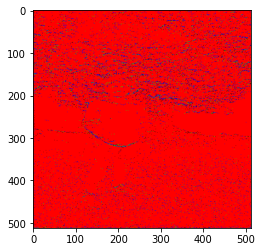

In [ ]:
img_path = f"{TEST_PATH}/sahas-standing.png"
pred_img = None
pred_img = tf.keras.preprocessing.image.load_img(img_path, target_size=(WIDTH, HEIGHT))
plt.imshow(pred_img)

pred_img = tf.keras.preprocessing.image.img_to_array(pred_img)

pred_img = tf.expand_dims(pred_img, 0)

pred_img = model.predict(pred_img)
output_mask = display_mask(pred_img)


output_mask = tf.squeeze(output_mask, axis=0)

mask_img1 = tf.keras.preprocessing.image.array_to_img(output_mask)

plt.imshow(mask_img1)